#

In [1]:
# Step 0: Install SHAP library quietly
%pip install -q shap
# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Import scikit-learn modules for preprocessing, splitting data, and evaluation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
# Step 3: Import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Step 4: Import SHAP for explainable AI
import shap
# Step 5: Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Device: cpu


# Load the dataset 

In [2]:
# from google.colab import files
# uploaded = files.upload()
import pandas as pd

df = pd.read_csv("updated_ckd_dataset_with_stages.csv")   # update file name
df.head()



,serum_creatinine,gfr,bun,serum_calcium,ana,c3_c4,hematuria,oxalate_levels,urine_ph,blood_pressure,...,smoking,alcohol,painkiller_usage,family_history,weight_changes,stress_level,months,cluster,ckd_pred,ckd_stage
0,0.683683,32.946784,7.553739,10.039896,0,138.204989,0,2.878164,7.864308,115.224217,...,yes,daily,no,yes,stable,low,10,5,CKD,3
1,3.809044,32.685035,141.347494,8.330543,1,24.282343,1,4.767639,4.920015,130.143900,...,yes,daily,no,yes,loss,moderate,1,2,CKD,3
2,1.143827,2.079805,15.979104,9.419229,0,163.970666,0,1.818613,6.188115,98.026072,...,no,daily,no,no,stable,moderate,4,6,CKD,5
3,4.804657,109.871407,53.307333,7.556631,1,71.056846,1,4.051686,5.278607,142.166650,...,no,never,yes,yes,stable,high,9,2,CKD,1
4,4.920235,42.214590,134.182157,7.289379,1,23.384639,1,3.240920,4.862923,151.962572,...,no,occasionally,yes,no,gain,high,7,2,CKD,3


## Loading and Preprocessing the CKD Dataset from a ZIP File

In [3]:
import zipfile
import pandas as pd
import os

zip_path = "DKD.zip"   # file must be in your project folder
extract_folder = "./extracted_data"

# Create folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Unzip DKD.zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Path to CSV inside the unzipped folder
csv_path = os.path.join(extract_folder, "updated_ckd_dataset_with_stages.csv")

# Load CSV
df = pd.read_csv(csv_path)

FEATURE_COLS = [
    "serum_creatinine",
    "gfr",
    "bun",
    "serum_calcium",
    "ana",
    "c3_c4",
    "hematuria",
    "oxalate_levels",
    "urine_ph",
    "blood_pressure",
    "months"
]

# Keep only columns that exist
FEATURE_COLS = [c for c in FEATURE_COLS if c in df.columns]
print("Using features:", FEATURE_COLS)

BINARY_LABEL_COL = "ckd_pred"
STAGE_LABEL_COL = "ckd_stage"

# Clean missing values
df = df.fillna(df.median(numeric_only=True))

print(df[BINARY_LABEL_COL].value_counts())
print(df[STAGE_LABEL_COL].value_counts())


Using features: ['serum_creatinine', 'gfr', 'bun', 'serum_calcium', 'ana', 'c3_c4', 'hematuria', 'oxalate_levels', 'urine_ph', 'blood_pressure', 'months']
ckd_pred
CKD       3875
No CKD     125
Name: count, dtype: int64
ckd_stage
2    1004
3     866
4     794
5     666
1     545
0     125
Name: count, dtype: int64


## Preparing Data for Binary CKD Classification

In [4]:
df_bin = df.dropna(subset=FEATURE_COLS + [BINARY_LABEL_COL])

# Map 'CKD' to 1 and 'No CKD' to 0 for binary classification
df_bin[BINARY_LABEL_COL] = df_bin[BINARY_LABEL_COL].apply(lambda x: 1 if x == 'CKD' else 0)

X_bin = df_bin[FEATURE_COLS].values
y_bin = df_bin[BINARY_LABEL_COL].astype(int).values

print("Binary data:", X_bin.shape, y_bin.shape)

Binary data: (4000, 11) (4000,)


## Splitting and Scaling Data for Binary CKD Classification

In [5]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

scaler_bin = StandardScaler()
Xb_train_sc = scaler_bin.fit_transform(Xb_train)
Xb_test_sc  = scaler_bin.transform(Xb_test)


## Creating a PyTorch Dataset for Tabular Data

In [6]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


## Defining a Multi-Layer Perceptron (MLP) Model in PyTorch

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)


## Training Function for PyTorch MLP Model

In [8]:
def train_model(model, train_loader, val_loader=None, epochs=30, lr=1e-3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)

        avg_loss = total_loss / len(train_loader.dataset)

        # validation accuracy
        if val_loader:
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for Xv, yv in val_loader:
                    Xv = Xv.to(device)
                    yv = yv.to(device)
                    preds = model(Xv).argmax(dim=1)
                    correct += (preds == yv).sum().item()
                    total += yv.size(0)
            acc = correct / total
            print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Val Acc: {acc:.4f}")

    return model


## Training the Binary CKD (DKD Yes/No) Model

In [9]:
batch_size = 64

train_ds_bin = TabularDataset(Xb_train_sc, yb_train)
test_ds_bin  = TabularDataset(Xb_test_sc,  yb_test)

train_loader_bin = DataLoader(train_ds_bin, batch_size=batch_size, shuffle=True)
test_loader_bin  = DataLoader(test_ds_bin,  batch_size=batch_size, shuffle=False)

input_dim = Xb_train_sc.shape[1]
model_bin = MLP(input_dim, 2)

print("Training DKD Yes/No model...")
model_bin = train_model(model_bin, train_loader_bin, test_loader_bin, epochs=30)


Training DKD Yes/No model...
Epoch 001 | Loss: 0.2952 | Val Acc: 0.9688
Epoch 002 | Loss: 0.1052 | Val Acc: 0.9688
Epoch 003 | Loss: 0.0829 | Val Acc: 0.9688
Epoch 004 | Loss: 0.0673 | Val Acc: 0.9688
Epoch 005 | Loss: 0.0565 | Val Acc: 0.9750
Epoch 006 | Loss: 0.0475 | Val Acc: 0.9838
Epoch 007 | Loss: 0.0421 | Val Acc: 0.9888
Epoch 008 | Loss: 0.0389 | Val Acc: 0.9912
Epoch 009 | Loss: 0.0352 | Val Acc: 0.9938
Epoch 010 | Loss: 0.0334 | Val Acc: 0.9925
Epoch 011 | Loss: 0.0312 | Val Acc: 0.9938
Epoch 012 | Loss: 0.0307 | Val Acc: 0.9912
Epoch 013 | Loss: 0.0312 | Val Acc: 0.9938
Epoch 014 | Loss: 0.0317 | Val Acc: 0.9950
Epoch 015 | Loss: 0.0254 | Val Acc: 0.9925
Epoch 016 | Loss: 0.0292 | Val Acc: 0.9938
Epoch 017 | Loss: 0.0277 | Val Acc: 0.9950
Epoch 018 | Loss: 0.0257 | Val Acc: 0.9962
Epoch 019 | Loss: 0.0246 | Val Acc: 0.9950
Epoch 020 | Loss: 0.0227 | Val Acc: 0.9950
Epoch 021 | Loss: 0.0237 | Val Acc: 0.9962
Epoch 022 | Loss: 0.0248 | Val Acc: 0.9950
Epoch 023 | Loss: 0.0227 

## Evaluating the Binary CKD (DKD Yes/No) Model

In [10]:
model_bin.eval()
preds, true = [], []

with torch.no_grad():
    for Xb, yb in test_loader_bin:
        Xb = Xb.to(device)
        p = model_bin(Xb).argmax(dim=1).cpu().numpy()
        preds.extend(p)
        true.extend(yb.numpy())

print("=== DKD Early Detection ===")
print(confusion_matrix(true, preds))
print(classification_report(true, preds, digits=4))


=== DKD Early Detection ===
[[ 20   5]
 [  0 775]]
              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889        25
           1     0.9936    1.0000    0.9968       775

    accuracy                         0.9938       800
   macro avg     0.9968    0.9000    0.9428       800
weighted avg     0.9938    0.9938    0.9934       800



## Preparing Data for CKD Stage Classification

In [11]:
df_stage = df.dropna(subset=FEATURE_COLS + [STAGE_LABEL_COL])

X_stage = df_stage[FEATURE_COLS].values
y_stage = df_stage[STAGE_LABEL_COL].astype(int).values

print("Stage data:", X_stage.shape, y_stage.shape)


Stage data: (4000, 11) (4000,)


## Splitting and Scaling Data for CKD Stage Classification

In [12]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_stage, y_stage, test_size=0.2, random_state=42, stratify=y_stage
)

scaler_stage = StandardScaler()
Xs_train_sc = scaler_stage.fit_transform(Xs_train)
Xs_test_sc  = scaler_stage.transform(Xs_test)


## Adjusting Labels for CKD Stage Classification

In [13]:
ys_train0 = ys_train - ys_train.min()
ys_test0  = ys_test  - ys_test.min()

num_classes = len(np.unique(ys_train0))
print("Stage classes:", num_classes)


Stage classes: 6


## Training the Multi-Class CKD Stage Prediction Model

In [14]:
train_ds_stage = TabularDataset(Xs_train_sc, ys_train0)
test_ds_stage  = TabularDataset(Xs_test_sc,  ys_test0)

train_loader_stage = DataLoader(train_ds_stage, batch_size=64, shuffle=True)
test_loader_stage  = DataLoader(test_ds_stage,  batch_size=64, shuffle=False)

input_dim_stage = Xs_train_sc.shape[1]
model_stage = MLP(input_dim_stage, num_classes)

print("Training Stage Prediction model...")
model_stage = train_model(model_stage, train_loader_stage, test_loader_stage, epochs=40)


Training Stage Prediction model...
Epoch 001 | Loss: 1.6265 | Val Acc: 0.4500
Epoch 002 | Loss: 1.2132 | Val Acc: 0.7612
Epoch 003 | Loss: 0.9134 | Val Acc: 0.8263
Epoch 004 | Loss: 0.7491 | Val Acc: 0.8512
Epoch 005 | Loss: 0.6416 | Val Acc: 0.8688
Epoch 006 | Loss: 0.5829 | Val Acc: 0.8838
Epoch 007 | Loss: 0.5243 | Val Acc: 0.8738
Epoch 008 | Loss: 0.4753 | Val Acc: 0.9150
Epoch 009 | Loss: 0.4479 | Val Acc: 0.9213
Epoch 010 | Loss: 0.4175 | Val Acc: 0.9062
Epoch 011 | Loss: 0.4040 | Val Acc: 0.9050
Epoch 012 | Loss: 0.3707 | Val Acc: 0.9287
Epoch 013 | Loss: 0.3571 | Val Acc: 0.9300
Epoch 014 | Loss: 0.3483 | Val Acc: 0.9287
Epoch 015 | Loss: 0.3329 | Val Acc: 0.9550
Epoch 016 | Loss: 0.3151 | Val Acc: 0.9400
Epoch 017 | Loss: 0.3190 | Val Acc: 0.9375
Epoch 018 | Loss: 0.2914 | Val Acc: 0.9550
Epoch 019 | Loss: 0.2808 | Val Acc: 0.9425
Epoch 020 | Loss: 0.2775 | Val Acc: 0.9413
Epoch 021 | Loss: 0.2734 | Val Acc: 0.9500
Epoch 022 | Loss: 0.2685 | Val Acc: 0.9450
Epoch 023 | Loss: 0

## Evaluating the Multi-Class CKD Stage Prediction Model

In [15]:
model_stage.eval()
s_preds, s_true = [], []

with torch.no_grad():
    for Xs, ys in test_loader_stage:
        Xs = Xs.to(device)
        p = model_stage(Xs).argmax(dim=1).cpu().numpy()
        s_preds.extend(p)
        s_true.extend(ys.numpy())

print("=== DKD Stage Prediction ===")
print(confusion_matrix(s_true, s_preds))
print(classification_report(s_true, s_preds, digits=4))


=== DKD Stage Prediction ===
[[ 24   1   0   0   0   0]
 [  2  98   9   0   0   0]
 [  0   0 199   2   0   0]
 [  0   0   7 163   3   0]
 [  0   0   0   4 153   2]
 [  0   0   0   0   6 127]]
              precision    recall  f1-score   support

           0     0.9231    0.9600    0.9412        25
           1     0.9899    0.8991    0.9423       109
           2     0.9256    0.9900    0.9567       201
           3     0.9645    0.9422    0.9532       173
           4     0.9444    0.9623    0.9533       159
           5     0.9845    0.9549    0.9695       133

    accuracy                         0.9550       800
   macro avg     0.9553    0.9514    0.9527       800
weighted avg     0.9562    0.9550    0.9549       800



##  Random Forest – Binary CKD Prediction

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize Random Forest
rf_bin = RandomForestClassifier(n_estimators=200, random_state=42)

# Train
rf_bin.fit(Xb_train_sc, yb_train)

# Predict
y_pred_rf_bin = rf_bin.predict(Xb_test_sc)

# Evaluation
print("=== Random Forest: Binary CKD Prediction ===")
print(confusion_matrix(yb_test, y_pred_rf_bin))
print(classification_report(yb_test, y_pred_rf_bin, digits=4))


=== Random Forest: Binary CKD Prediction ===
[[ 20   5]
 [  2 773]]
              precision    recall  f1-score   support

           0     0.9091    0.8000    0.8511        25
           1     0.9936    0.9974    0.9955       775

    accuracy                         0.9912       800
   macro avg     0.9513    0.8987    0.9233       800
weighted avg     0.9909    0.9912    0.9910       800



## XGBoost – Binary CKD Prediction

In [17]:
import xgboost as xgb 

# Initialize XGBoost classifier
xgb_bin = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train
xgb_bin.fit(Xb_train_sc, yb_train)

# Predict
y_pred_xgb_bin = xgb_bin.predict(Xb_test_sc)

# Evaluation
print("=== XGBoost: Binary CKD Prediction ===")
print(confusion_matrix(yb_test, y_pred_xgb_bin))
print(classification_report(yb_test, y_pred_xgb_bin, digits=4))


=== XGBoost: Binary CKD Prediction ===
[[ 22   3]
 [  2 773]]
              precision    recall  f1-score   support

           0     0.9167    0.8800    0.8980        25
           1     0.9961    0.9974    0.9968       775

    accuracy                         0.9938       800
   macro avg     0.9564    0.9387    0.9474       800
weighted avg     0.9937    0.9938    0.9937       800



c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:12:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Random Forest – CKD Stage Prediction

In [18]:
# Initialize Random Forest for multi-class
rf_stage = RandomForestClassifier(n_estimators=200, random_state=42)

# Train
rf_stage.fit(Xs_train_sc, ys_train0)

# Predict
y_pred_rf_stage = rf_stage.predict(Xs_test_sc)

# Evaluation
print("=== Random Forest: CKD Stage Prediction ===")
print(confusion_matrix(ys_test0, y_pred_rf_stage))
print(classification_report(ys_test0, y_pred_rf_stage, digits=4))


=== Random Forest: CKD Stage Prediction ===
[[ 20   5   0   0   0   0]
 [  1 108   0   0   0   0]
 [  0   0 201   0   0   0]
 [  0   0   0 173   0   0]
 [  0   0   0   0 159   0]
 [  0   0   0   0   1 132]]
              precision    recall  f1-score   support

           0     0.9524    0.8000    0.8696        25
           1     0.9558    0.9908    0.9730       109
           2     1.0000    1.0000    1.0000       201
           3     1.0000    1.0000    1.0000       173
           4     0.9938    1.0000    0.9969       159
           5     1.0000    0.9925    0.9962       133

    accuracy                         0.9912       800
   macro avg     0.9836    0.9639    0.9726       800
weighted avg     0.9912    0.9912    0.9910       800



## XGBoost – CKD Stage Prediction

In [19]:
# Initialize XGBoost classifier for multi-class
xgb_stage = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train
xgb_stage.fit(Xs_train_sc, ys_train0)

# Predict
y_pred_xgb_stage = xgb_stage.predict(Xs_test_sc)

# Evaluation
print("=== XGBoost: CKD Stage Prediction ===")
print(confusion_matrix(ys_test0, y_pred_xgb_stage))
print(classification_report(ys_test0, y_pred_xgb_stage, digits=4))


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:13:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost: CKD Stage Prediction ===
[[ 22   3   0   0   0   0]
 [  1 107   1   0   0   0]
 [  0   0 201   0   0   0]
 [  0   0   0 170   3   0]
 [  0   0   0   0 157   2]
 [  0   0   0   0   1 132]]
              precision    recall  f1-score   support

           0     0.9565    0.8800    0.9167        25
           1     0.9727    0.9817    0.9772       109
           2     0.9950    1.0000    0.9975       201
           3     1.0000    0.9827    0.9913       173
           4     0.9752    0.9874    0.9812       159
           5     0.9851    0.9925    0.9888       133

    accuracy                         0.9862       800
   macro avg     0.9808    0.9707    0.9754       800
weighted avg     0.9863    0.9862    0.9862       800



## Prepare Data for PyTorch

In [20]:
# Binary target
BINARY_LABEL = 'ckd_pred'

# Multi-class target (stage)
STAGE_LABEL = 'ckd_stage'
FEATURE_COLS = [
    "serum_creatinine",
    "gfr",
    "bun",
    "serum_calcium",
    "ana",
    "c3_c4",
    "hematuria",
    "oxalate_levels",
    "urine_ph",
    "blood_pressure",
    "months"
]

In [21]:
# Binary classification
X_bin = df[FEATURE_COLS].values
y_bin = df[BINARY_LABEL].values

# Stage prediction
X_stage = df[FEATURE_COLS].values
y_stage = df[STAGE_LABEL].astype(int).values


## Train/Test Split & Scaling

In [22]:
# ==========================
# Binary CKD Prediction Split
# ==========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

scaler_bin = StandardScaler()
Xb_train_sc = scaler_bin.fit_transform(Xb_train)
Xb_test_sc = scaler_bin.transform(Xb_test)

# ==========================
# CKD Stage Prediction Split
# ==========================
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_stage, y_stage, test_size=0.2, random_state=42, stratify=y_stage
)

scaler_stage = StandardScaler()
Xs_train_sc = scaler_stage.fit_transform(Xs_train)
Xs_test_sc = scaler_stage.transform(Xs_test)


## PyTorch Dataset & DataLoader

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# Binary CKD: Map to 0/1
# -----------------------------
y_bin = np.array([1 if val=='CKD' else 0 for val in y_bin])

# -----------------------------
# Train/Test Split
# -----------------------------
# Binary CKD
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

scaler_bin = StandardScaler()
Xb_train_sc = scaler_bin.fit_transform(Xb_train)
Xb_test_sc = scaler_bin.transform(Xb_test)

# Stage prediction (already numeric)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_stage, y_stage, test_size=0.2, random_state=42, stratify=y_stage
)

scaler_stage = StandardScaler()
Xs_train_sc = scaler_stage.fit_transform(Xs_train)
Xs_test_sc = scaler_stage.transform(Xs_test)

# -----------------------------
# PyTorch Dataset
# -----------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

# Binary CKD
train_ds_bin = TabularDataset(Xb_train_sc, yb_train)
test_ds_bin = TabularDataset(Xb_test_sc, yb_test)
train_loader_bin = DataLoader(train_ds_bin, batch_size=batch_size, shuffle=True)
test_loader_bin = DataLoader(test_ds_bin, batch_size=batch_size, shuffle=False)

# Stage prediction (0-index)
num_classes = len(np.unique(ys_train))
train_ds_stage = TabularDataset(Xs_train_sc, ys_train-1)
test_ds_stage = TabularDataset(Xs_test_sc, ys_test-1)
train_loader_stage = DataLoader(train_ds_stage, batch_size=batch_size, shuffle=True)
test_loader_stage = DataLoader(test_ds_stage, batch_size=batch_size, shuffle=False)


## Define MLP Model

In [24]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# --------------------------
# Model Instances
# --------------------------
input_dim = Xb_train_sc.shape[1]
model_bin = MLP(input_dim, 2)          # Binary CKD
model_stage = MLP(input_dim, num_classes)  # CKD Stage


## Training Function


In [25]:
import torch.optim as optim

def train_model(model, train_loader, val_loader=None, epochs=30, lr=1e-3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)

        avg_loss = total_loss / len(train_loader.dataset)

        # Validation Accuracy
        if val_loader:
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for Xv, yv in val_loader:
                    Xv, yv = Xv.to(device), yv.to(device)
                    preds = model(Xv).argmax(dim=1)
                    correct += (preds==yv).sum().item()
                    total += yv.size(0)
            acc = correct/total
            print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Val Acc: {acc:.4f}")
    return model


## Train Models

In [26]:
# -------------------------------
# Imports
# -------------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------------
# Load dataset
# -------------------------------
df = pd.read_csv("updated_ckd_dataset_with_stages.csv")

FEATURE_COLS = [
    "serum_creatinine","gfr","bun","serum_calcium",
    "ana","c3_c4","hematuria","oxalate_levels",
    "urine_ph","blood_pressure","months"
]

BINARY_LABEL = "ckd_pred"
STAGE_LABEL  = "ckd_stage"

# -------------------------------
# Preprocess labels
# -------------------------------
# Binary CKD: Map CKD->1, No CKD->0
df[BINARY_LABEL] = df[BINARY_LABEL].apply(lambda x: 1 if x=='CKD' else 0)

# Stage labels: convert to 0-based integers
df[STAGE_LABEL] = df[STAGE_LABEL].astype(int)
df['stage0'] = df[STAGE_LABEL] - df[STAGE_LABEL].min()  # 0-based

# -------------------------------
# Feature & label arrays
# -------------------------------
X_bin = df[FEATURE_COLS].values
y_bin = df[BINARY_LABEL].values

X_stage = df[FEATURE_COLS].values
y_stage = df['stage0'].values

# -------------------------------
# Train-test split
# -------------------------------
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_stage, y_stage, test_size=0.2, random_state=42, stratify=y_stage
)

# -------------------------------
# Scaling
# -------------------------------
scaler_bin = StandardScaler()
Xb_train_sc = scaler_bin.fit_transform(Xb_train)
Xb_test_sc  = scaler_bin.transform(Xb_test)

scaler_stage = StandardScaler()
Xs_train_sc = scaler_stage.fit_transform(Xs_train)
Xs_test_sc  = scaler_stage.transform(Xs_test)

# -------------------------------
# Dataset Class
# -------------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -------------------------------
# DataLoader
# -------------------------------
batch_size = 64

train_loader_bin = DataLoader(TabularDataset(Xb_train_sc, yb_train), batch_size=batch_size, shuffle=True)
test_loader_bin  = DataLoader(TabularDataset(Xb_test_sc, yb_test), batch_size=batch_size, shuffle=False)

train_loader_stage = DataLoader(TabularDataset(Xs_train_sc, ys_train), batch_size=batch_size, shuffle=True)
test_loader_stage  = DataLoader(TabularDataset(Xs_test_sc, ys_test), batch_size=batch_size, shuffle=False)

# -------------------------------
# MLP Model
# -------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# -------------------------------
# Training Function
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader=None, epochs=30, lr=1e-3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        avg_loss = total_loss / len(train_loader.dataset)

        if val_loader:
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for Xv, yv in val_loader:
                    Xv, yv = Xv.to(device), yv.to(device)
                    preds = model(Xv).argmax(dim=1)
                    correct += (preds == yv).sum().item()
                    total += yv.size(0)
            acc = correct / total
            print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Val Acc: {acc:.4f}")

    return model

# -------------------------------
# Model Initialization
# -------------------------------
input_dim = Xb_train_sc.shape[1]

model_bin   = MLP(input_dim, num_classes=2)
model_stage = MLP(input_dim, num_classes=len(np.unique(ys_train)))

# -------------------------------
# Training
# -------------------------------
print("Training Binary CKD Model...")
model_bin = train_model(model_bin, train_loader_bin, test_loader_bin, epochs=30)

print("Training CKD Stage Model...")
model_stage = train_model(model_stage, train_loader_stage, test_loader_stage, epochs=40)


Training Binary CKD Model...
Epoch 001 | Loss: 0.2268 | Val Acc: 0.9688
Epoch 002 | Loss: 0.0974 | Val Acc: 0.9688
Epoch 003 | Loss: 0.0711 | Val Acc: 0.9688
Epoch 004 | Loss: 0.0564 | Val Acc: 0.9700
Epoch 005 | Loss: 0.0493 | Val Acc: 0.9812
Epoch 006 | Loss: 0.0426 | Val Acc: 0.9825
Epoch 007 | Loss: 0.0399 | Val Acc: 0.9938
Epoch 008 | Loss: 0.0358 | Val Acc: 0.9938
Epoch 009 | Loss: 0.0348 | Val Acc: 0.9962
Epoch 010 | Loss: 0.0310 | Val Acc: 0.9950
Epoch 011 | Loss: 0.0304 | Val Acc: 0.9950
Epoch 012 | Loss: 0.0315 | Val Acc: 0.9912
Epoch 013 | Loss: 0.0316 | Val Acc: 0.9950
Epoch 014 | Loss: 0.0302 | Val Acc: 0.9938
Epoch 015 | Loss: 0.0283 | Val Acc: 0.9962
Epoch 016 | Loss: 0.0257 | Val Acc: 0.9962
Epoch 017 | Loss: 0.0241 | Val Acc: 0.9962
Epoch 018 | Loss: 0.0223 | Val Acc: 0.9962
Epoch 019 | Loss: 0.0244 | Val Acc: 0.9962
Epoch 020 | Loss: 0.0241 | Val Acc: 0.9962
Epoch 021 | Loss: 0.0247 | Val Acc: 0.9962
Epoch 022 | Loss: 0.0201 | Val Acc: 0.9962
Epoch 023 | Loss: 0.0217 

## Evaluation

In [27]:
from sklearn.metrics import classification_report, confusion_matrix




In [28]:

# --------------------------
# Binary CKD
# --------------------------
model_bin.eval()
preds_bin, true_bin = [], []

with torch.no_grad():
    for Xb, yb in test_loader_bin:
        Xb = Xb.to(device)
        preds_bin.extend(model_bin(Xb).argmax(dim=1).cpu().numpy())
        true_bin.extend(yb.numpy())

print("=== Binary CKD Prediction ===")
print(confusion_matrix(true_bin, preds_bin))
print(classification_report(true_bin, preds_bin, digits=4))

# --------------------------
# CKD Stage
# --------------------------
model_stage.eval()
preds_stage, true_stage = [], []

with torch.no_grad():
    for Xs, ys in test_loader_stage:
        Xs = Xs.to(device)
        preds_stage.extend(model_stage(Xs).argmax(dim=1).cpu().numpy())
        true_stage.extend(ys.numpy())

print("=== CKD Stage Prediction ===")
print(confusion_matrix(true_stage, preds_stage))
print(classification_report(true_stage, preds_stage, digits=4))


=== Binary CKD Prediction ===
[[ 24   1]
 [  2 773]]
              precision    recall  f1-score   support

           0     0.9231    0.9600    0.9412        25
           1     0.9987    0.9974    0.9981       775

    accuracy                         0.9962       800
   macro avg     0.9609    0.9787    0.9696       800
weighted avg     0.9963    0.9962    0.9963       800

=== CKD Stage Prediction ===
[[ 19   6   0   0   0   0]
 [  1  96  12   0   0   0]
 [  0   0 197   4   0   0]
 [  0   0   7 165   1   0]
 [  0   0   0   8 150   1]
 [  0   0   0   0  12 121]]
              precision    recall  f1-score   support

           0     0.9500    0.7600    0.8444        25
           1     0.9412    0.8807    0.9100       109
           2     0.9120    0.9801    0.9448       201
           3     0.9322    0.9538    0.9429       173
           4     0.9202    0.9434    0.9317       159
           5     0.9918    0.9098    0.9490       133

    accuracy                         0.9350     

In [29]:

# --------------------------
# Binary CKD
# --------------------------
model_bin.eval()
preds_bin, true_bin = [], []

with torch.no_grad():
    for Xb, yb in test_loader_bin:
        Xb = Xb.to(device)
        preds_bin.extend(model_bin(Xb).argmax(dim=1).cpu().numpy())
        true_bin.extend(yb.numpy())

print("=== Binary CKD Prediction ===")
print(confusion_matrix(true_bin, preds_bin))
print(classification_report(true_bin, preds_bin, digits=4))

# --------------------------
# CKD Stage
# --------------------------
model_stage.eval()
preds_stage, true_stage = [], []

with torch.no_grad():
    for Xs, ys in test_loader_stage:
        Xs = Xs.to(device)
        preds_stage.extend(model_stage(Xs).argmax(dim=1).cpu().numpy())
        true_stage.extend(ys.numpy())

print("=== CKD Stage Prediction ===")
print(confusion_matrix(true_stage, preds_stage))
print(classification_report(true_stage, preds_stage, digits=4))


=== Binary CKD Prediction ===
[[ 24   1]
 [  2 773]]
              precision    recall  f1-score   support

           0     0.9231    0.9600    0.9412        25
           1     0.9987    0.9974    0.9981       775

    accuracy                         0.9962       800
   macro avg     0.9609    0.9787    0.9696       800
weighted avg     0.9963    0.9962    0.9963       800

=== CKD Stage Prediction ===
[[ 19   6   0   0   0   0]
 [  1  96  12   0   0   0]
 [  0   0 197   4   0   0]
 [  0   0   7 165   1   0]
 [  0   0   0   8 150   1]
 [  0   0   0   0  12 121]]
              precision    recall  f1-score   support

           0     0.9500    0.7600    0.8444        25
           1     0.9412    0.8807    0.9100       109
           2     0.9120    0.9801    0.9448       201
           3     0.9322    0.9538    0.9429       173
           4     0.9202    0.9434    0.9317       159
           5     0.9918    0.9098    0.9490       133

    accuracy                         0.9350     

## Explainable AI (Optional: SHAP)

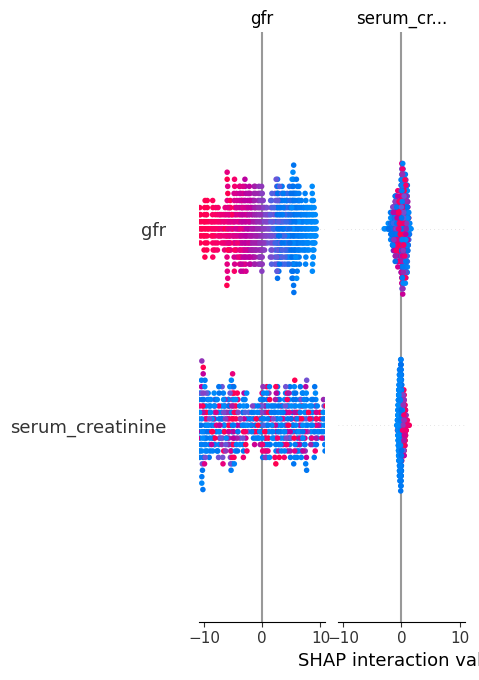

In [30]:
import shap

# SHAP DeepExplainer
explainer = shap.DeepExplainer(model_bin, torch.tensor(Xb_train_sc, dtype=torch.float32))
shap_values = explainer.shap_values(torch.tensor(Xb_test_sc, dtype=torch.float32))

shap.summary_plot(shap_values, Xb_test_sc, feature_names=FEATURE_COLS)


## Code (TabNetClassifier)

In [32]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split
Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

clf_bin = TabNetClassifier(
    n_d=16, n_a=16, n_steps=5,
    gamma=1.3, 
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,   # FIXED 🔥
    optimizer_params={"lr": 1e-3},   # recommended
    mask_type='entmax'
)

clf_bin.fit(
    Xb_tr, yb_tr,
    eval_set=[(Xb_te, yb_te)],
    max_epochs=50,
    patience=10,
    batch_size=64,
    virtual_batch_size=32,
    num_workers=0,
    drop_last=False
)

yb_pred = clf_bin.predict(Xb_te)
print("=== TabNet Binary Accuracy ===", accuracy_score(yb_te, yb_pred))


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.38374 | val_0_auc: 0.7177  |  0:00:01s
epoch 1  | loss: 0.13147 | val_0_auc: 0.692   |  0:00:02s
epoch 2  | loss: 0.1045  | val_0_auc: 0.79355 |  0:00:03s
epoch 3  | loss: 0.08522 | val_0_auc: 0.93672 |  0:00:04s
epoch 4  | loss: 0.07788 | val_0_auc: 0.96351 |  0:00:06s
epoch 5  | loss: 0.07343 | val_0_auc: 0.97605 |  0:00:07s
epoch 6  | loss: 0.06261 | val_0_auc: 0.98839 |  0:00:08s
epoch 7  | loss: 0.06013 | val_0_auc: 0.99215 |  0:00:10s
epoch 8  | loss: 0.06358 | val_0_auc: 0.99468 |  0:00:11s
epoch 9  | loss: 0.05662 | val_0_auc: 0.9952  |  0:00:12s
epoch 10 | loss: 0.05383 | val_0_auc: 0.99195 |  0:00:13s
epoch 11 | loss: 0.05239 | val_0_auc: 0.99634 |  0:00:14s
epoch 12 | loss: 0.05386 | val_0_auc: 0.99427 |  0:00:15s
epoch 13 | loss: 0.04799 | val_0_auc: 0.99711 |  0:00:17s
epoch 14 | loss: 0.04323 | val_0_auc: 0.99845 |  0:00:18s
epoch 15 | loss: 0.0495  | val_0_auc: 0.9984  |  0:00:20s
epoch 16 | loss: 0.05327 | val_0_auc: 0.99917 |  0:00:21s
epoch 17 | los

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


=== TabNet Binary Accuracy === 0.99375


In [35]:
import torch
import torch.nn as nn

class TabTransformerBlock(nn.Module):
    def __init__(self, dim, heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.ReLU(),
            nn.Linear(dim*4, dim),
        )
        self.ln2 = nn.LayerNorm(dim)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.ln1(x + attn_out)
        ff_out = self.ff(x)
        x = self.ln2(x + ff_out)
        return x


class TabTransformer(nn.Module):
    def __init__(self, num_features, dim=64, depth=4, heads=4, num_classes=2):
        super().__init__()
        self.embed = nn.Linear(1, dim)

        self.blocks = nn.ModuleList([
            TabTransformerBlock(dim, heads) for _ in range(depth)
        ])

        self.mlp = nn.Sequential(
            nn.Linear(num_features * dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x shape: (batch, features)
        x = x.unsqueeze(-1)  # (batch, features, 1)
        x = self.embed(x)    # (batch, features, dim)

        for block in self.blocks:
            x = block(x)

        x = x.reshape(x.size(0), -1)  # flatten
        return self.mlp(x)


## Code (TabTransformer via pytorch_tabular) 

In [37]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("updated_ckd_dataset_with_stages.csv")

FEATURE_COLS = ["serum_creatinine","gfr","bun","serum_calcium","ana","c3_c4",
                "hematuria","oxalate_levels","urine_ph","blood_pressure","months"]

# binary label
df["binary_label"] = df["ckd_pred"].apply(lambda x: 1 if x == "CKD" else 0)

X = df[FEATURE_COLS].values.astype(np.float32)
y = df["binary_label"].values.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

# Model Init
model = TabTransformer(
    num_features=X.shape[1],
    dim=32,
    depth=4,
    heads=4,
    num_classes=2
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training
for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = loss_fn(logits, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} Loss = {loss.item():.4f}")

# Evaluation
model.eval()
y_pred = torch.argmax(model(X_test), dim=1).numpy()

print("\n=== TabTransformer Accuracy ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


Epoch 5 Loss = 0.1484
Epoch 10 Loss = 0.1364
Epoch 15 Loss = 0.1326
Epoch 20 Loss = 0.1282
Epoch 25 Loss = 0.1204
Epoch 30 Loss = 0.1088

=== TabTransformer Accuracy ===
Accuracy: 0.96875
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        25
           1     0.9688    1.0000    0.9841       775

    accuracy                         0.9688       800
   macro avg     0.4844    0.5000    0.4921       800
weighted avg     0.9385    0.9688    0.9534       800



c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

## Code (AutoGluon)

In [38]:
# AutoGluon for tabular classification
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("updated_ckd_dataset_with_stages.csv")

FEATURE_COLS = ["serum_creatinine","gfr","bun","serum_calcium","ana","c3_c4",
                "hematuria","oxalate_levels","urine_ph","blood_pressure","months"]

# Prepare binary dataset for AutoGluon (it accepts raw DataFrame)
df_ag = df[FEATURE_COLS + ["ckd_pred"]].copy()
# Ensure label is string or numeric; AutoGluon handles both
df_ag['ckd_pred'] = df_ag['ckd_pred'].astype(str)

train_df, test_df = train_test_split(df_ag, test_size=0.2, random_state=42, stratify=df_ag['ckd_pred'])

predictor = TabularPredictor(label='ckd_pred', eval_metric='accuracy', path='AutogluonModels/CKD').fit(
    train_df,
    time_limit=600,  # seconds; adjust (e.g., 600 -> 10 minutes). Remove or increase for better results.
    presets='medium_quality_faster_train'
)

# Evaluate
perf = predictor.evaluate(test_df)
print("AutoGluon Binary performance:", perf)

# For stage multiclass:
df_ag_stage = df[FEATURE_COLS + ['ckd_stage']].copy()
df_ag_stage['ckd_stage'] = df_ag_stage['ckd_stage'].astype(str)
train_s, test_s = train_test_split(df_ag_stage, test_size=0.2, random_state=42, stratify=df_ag_stage['ckd_stage'])
predictor_stage = TabularPredictor(label='ckd_stage', eval_metric='accuracy', path='AutogluonModels/Stage').fit(
    train_s, time_limit=600, presets='medium_quality_faster_train'
)
predictor_stage.evaluate(test_s)


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.1b20251210
Python Version:     3.13.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          8
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       1.37 GB / 11.73 GB (11.7%)
Disk Space Avail:   35.06 GB / 237.61 GB (14.8%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "c:\Users\DELL\Downloads\Telegram Desktop\DKD\AutogluonModels\CKD"
Train Data Rows:    3200
Train Data Columns: 11
Label Column:       ckd_pred
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['CKD', 'No CKD']
	If 'binary' is not t

AutoGluon Binary performance: {'accuracy': 0.9975, 'balanced_accuracy': np.float64(0.96), 'mcc': 0.9579310610017391, 'roc_auc': np.float64(1.0), 'f1': 0.9583333333333334, 'precision': 1.0, 'recall': 0.92}


	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 6
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1117.24 MB
	Train Data (Original)  Memory Usage: 0.27 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting 

{'accuracy': 0.99125,
 'balanced_accuracy': np.float64(0.9587468671679198),
 'mcc': 0.9891697857983982}